In [1]:
import os
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch.nn.functional as F
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

from torch import nn
from tqdm import tqdm
from datasets import load_metric
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

/home/nplab/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/nplab/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
class SkinDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks')
        
        self.image_files = sorted([f for f in os.listdir(self.image_dir) if os.path.isfile(os.path.join(self.image_dir, f))])
        self.mask_files = sorted([f for f in os.listdir(self.mask_dir) if os.path.isfile(os.path.join(self.mask_dir, f))])
        
        self.transform = transform
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        unique_values = np.unique(mask)
        image = self.transform(image)

        mask_np = np.array(mask)
        masks = [(mask_np == val).astype(int) for val in range(3)]
        mask = np.stack(masks, axis=0)
        mask = torch.tensor(mask, dtype=torch.float32)
        return image, mask

        
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])

train_data = SkinDataset(root_dir='../../../../Datasets/NewSkinDataset/original/train', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

for images, masks in train_loader:
    print(images.shape, masks.shape)
    break


torch.Size([32, 3, 640, 640]) torch.Size([32, 3, 640, 640])


In [5]:
import torch
import torch.nn.functional as F
from torch import nn
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from datasets import load_metric
from torchvision import transforms
from PIL import Image
import pandas as pd



class LitEfficientNet(pl.LightningModule):
    def __init__(self, train_dataloader=None, val_dataloader=None, test_dataloader=None, batch_size=32):
        super(LitEfficientNet, self).__init__()
        self.train_data_loader = train_dataloader
        self.val_data_loader = val_dataloader
        self.test_data_loader = test_dataloader
        self.model = smp.Unet(
            encoder_name="efficientnet-b3", 
            encoder_weights="imagenet", 
            in_channels=3, 
            classes=3
        )
        #self.criterion = nn.CrossEntropyLoss()
        self.criterion = nn.CrossEntropyLoss(ignore_index=0)  # background 제외
        self.train_mean_iou = load_metric("mean_iou")
        self.val_mean_iou = load_metric("mean_iou")
        self.test_mean_iou = load_metric("mean_iou")
        self.batch_size = batch_size

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.argmax(dim=1)
        preds = self(x)
        loss = F.cross_entropy(preds, y)

        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y = y.argmax(dim=1)
        preds = self(x)

        loss = F.cross_entropy(preds, y)

        self.log('val_loss', loss)
        return {'val_loss': loss}
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y = y.argmax(dim=1)
        preds = self(x)
        loss = F.cross_entropy(preds, y)

        return {'test_loss': loss}

    
    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=1e-08, eps=1e-08)
    
    def train_dataloader(self):
        return self.train_data_loader
    
    def val_dataloader(self):
        return self.val_data_loader
    
    def test_dataloader(self):
        return self.test_data_loader


In [6]:
load_model = LitEfficientNet.load_from_checkpoint(checkpoint_path='./model_pt/2023_09_12_backgournd_remove.ckpt')


In [7]:
train_data = SkinDataset(root_dir='../../../../Datasets/NewSkinDataset/original/train', transform=transform)
train_loader = DataLoader(train_data, batch_size=1, shuffle=False)


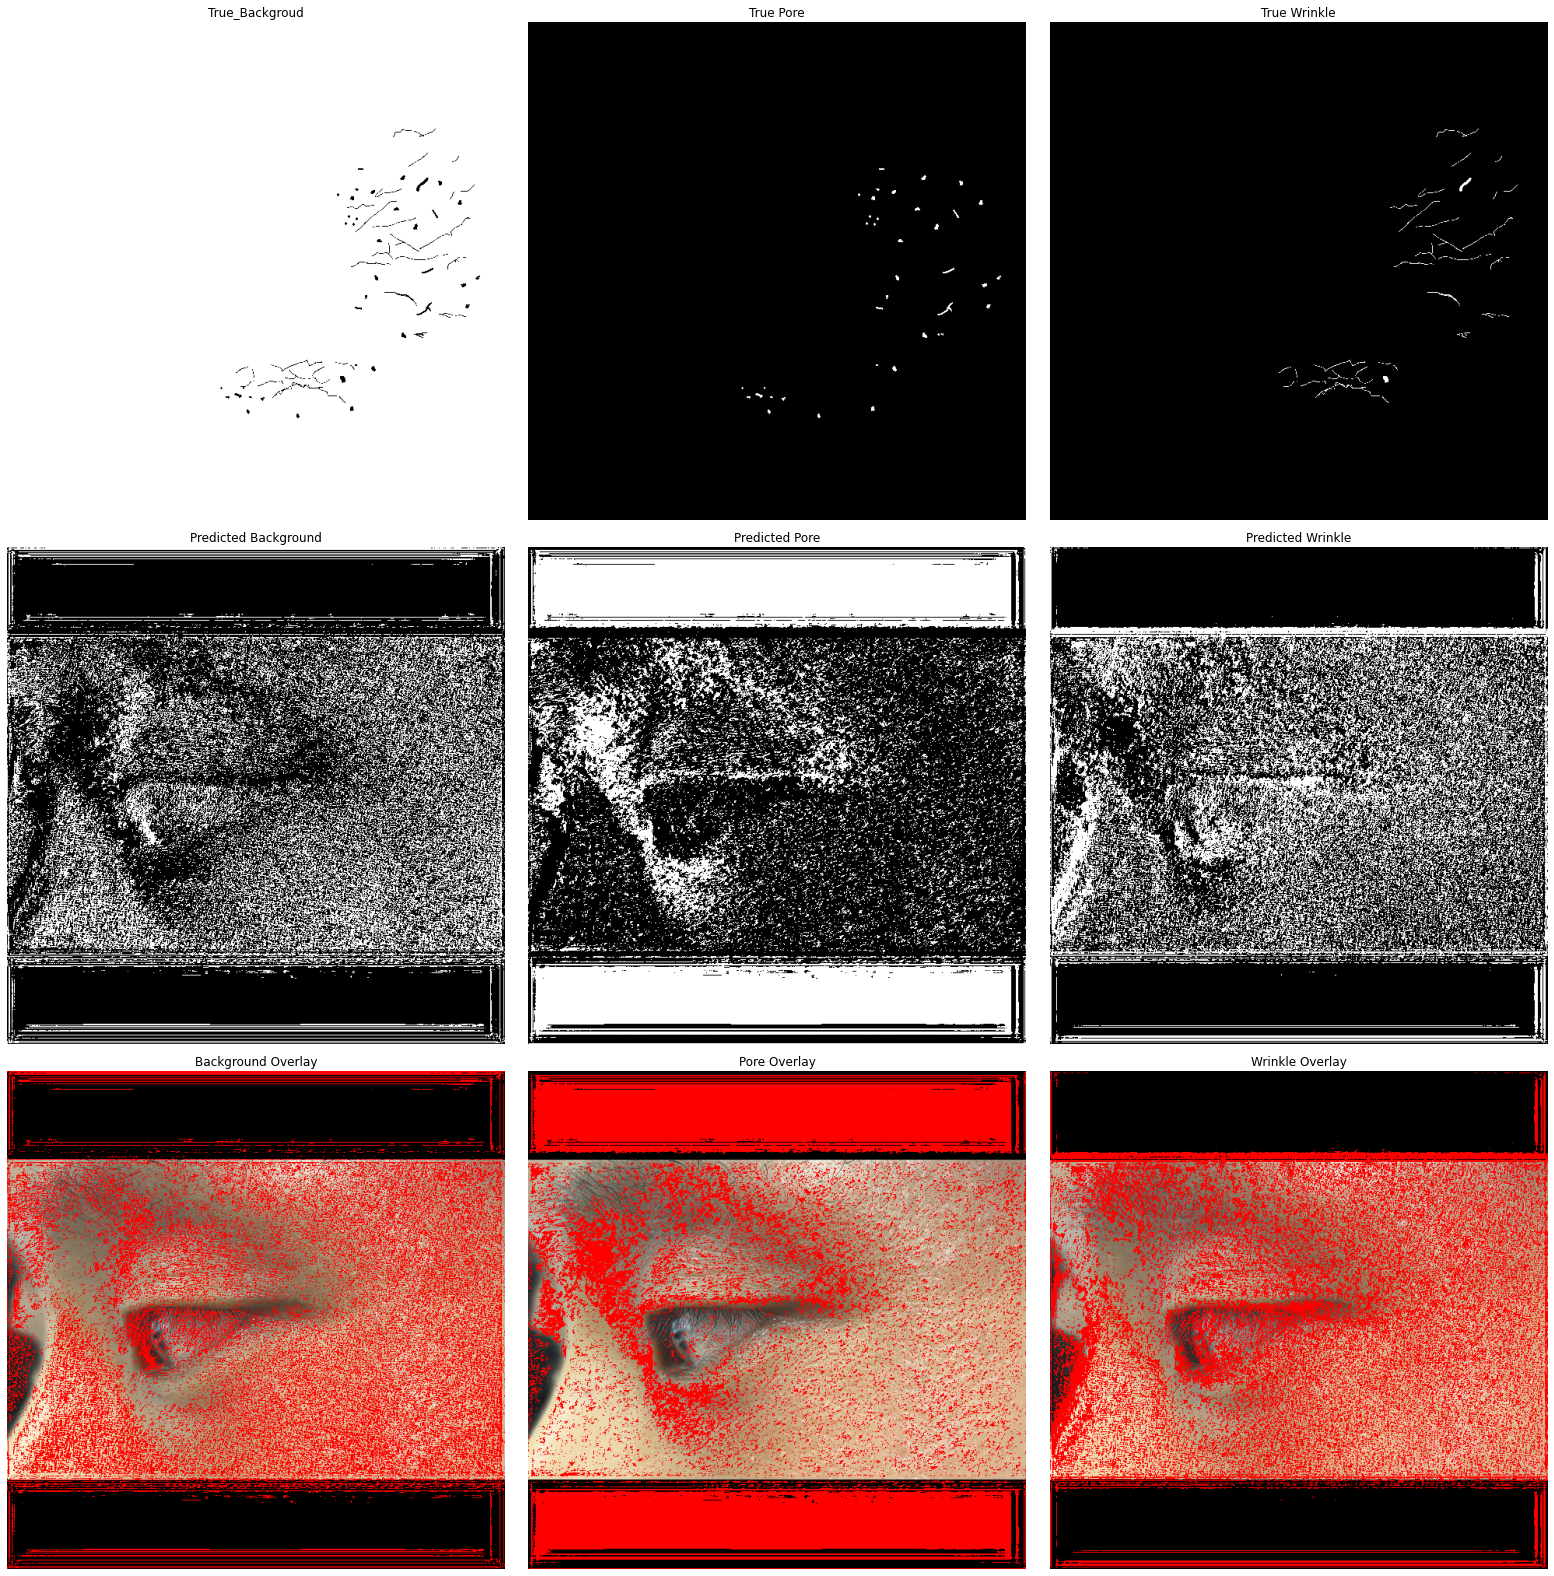

In [9]:
for img_idx, batch in enumerate(train_loader):
    x, y = batch
    x, y = x.to('cpu'), y.to('cpu')
    
    logits = load_model(x)
    
    probs = torch.nn.functional.softmax(logits, dim=1)
    y_pred_plot = probs.argmax(dim=1).detach().cpu().numpy()
    to_plot = x.detach().cpu().numpy()
    y_true_plot = y.detach().cpu().numpy()

    fig, axs = plt.subplots(3, 3, figsize=(22, 22))

    for i, label in enumerate(['True_Backgroud', 'True Pore', 'True Wrinkle']):
        mask = y_true_plot[0][i]  # 각 클래스에 대한 마스크를 가져옵니다.
        axs[0, i].imshow(mask, cmap='gray')
        axs[0, i].set_title(label)

    for i, label in enumerate(['Predicted Background', 'Predicted Pore', 'Predicted Wrinkle']):
        mask = (y_pred_plot[0] == i)  # 예측된 클래스에 대한 마스크 생성
        axs[1, i].imshow(mask, cmap='gray')
        axs[1, i].set_title(label)

    for i, label in enumerate(['Background Overlay', 'Pore Overlay', 'Wrinkle Overlay']):
        overlay_image = to_plot[0].transpose((1, 2, 0)).copy()
        mask = (y_pred_plot[0] == i)
        overlay_image[mask] = [255, 0, 0]  # 예측된 영역을 빨간색으로 표시합니다.
        axs[2, i].imshow(overlay_image, cmap='gray')
        axs[2, i].set_title(label)

    for ax in axs.ravel():
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'result/2023_09_13_init_test/b3/image_{img_idx}.png')
    plt.show()
    break


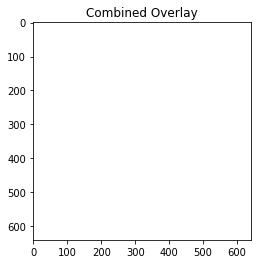

In [10]:
import numpy as np

combined_mask = np.zeros_like(mask[0], dtype=bool)
overlay_image = to_plot[0].transpose((1, 2, 0)).copy()

for i in range(3):
    mask = (y_pred_plot[0] == i)
    combined_mask = np.logical_or(combined_mask, mask)

overlay_image[combined_mask] = [255, 255, 255]

plt.imshow(overlay_image, cmap='gray')
plt.title('Combined Overlay')
plt.show()


In [11]:
from datasets import load_metric
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# 미리 정의된 load_model과 train_loader가 있다고 가정합니다.

metric = load_metric("mean_iou")
results = []

for img_idx, batch in tqdm(enumerate(train_loader)):
    x, y = batch
    x, y = x.to('cpu'), y.to('cpu')
    
    logits = load_model(x)
    probs = torch.nn.functional.softmax(logits, dim=1)
    
    y_pred_plot = probs.argmax(dim=1).detach().cpu().numpy()
    y_true_plot = y.detach().cpu().numpy()
    

    y_true_squeezed = y_true_plot[0].squeeze()

    
    miou_values = {}

    print(y_pred_plot.shape)
    print(y_true_squeezed.shape)
    miou = metric.compute(predictions=[y_pred_plot], 
                          references=[y_true_squeezed], 
                          num_labels=3, ignore_index = 255)['per_category_iou']

    miou_values['img_idx'] = img_idx
    miou_values['background_miou'] = miou[0]
    miou_values['pore_miou'] = miou[1]
    miou_values['wrinkle_miou'] = miou[2]
    
    results.append(miou_values)

# 결과를 데이터 프레임으로 변환
miou_df = pd.DataFrame(results)
miou_df


0it [00:00, ?it/s]

(1, 640, 640)
(3, 640, 640)


TypeError: only size-1 arrays can be converted to Python scalars

In [12]:
import numpy as np


label_0 = np.where(y_true_plot[0][0, :, :] == 1, 0, -1)
label_1 = np.where(y_true_plot[0][1, :, :] == 1, 1, -1)
label_2 = np.where(y_true_plot[0][2, :, :] == 1, 2, -1)

# 최종 레이블 배열을 얻기 위해 개별 레이블 배열을 합칩니다.
# np.maximum을 사용하여 각 위치에서 최대값을 선택합니다.
y_true_combined = np.maximum(label_0, np.maximum(label_1, label_2))

# 이제y_true_plot_combined는 모양이 (640, 640)이고, 각 위치에는 0, 1 또는 2의 레이블이 있습니다.


In [13]:
unique_values = np.unique(y_true_combined)

print(unique_values)

[0 1 2]


In [14]:

unique_values = np.unique(y_pred_plot)
print(unique_values)

[0 1 2]


In [15]:
from datasets import load_metric
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch

# 미리 정의된 load_model과 train_loader가 있다고 가정합니다.

metric = load_metric("mean_iou")
results = []

for img_idx, batch in tqdm(enumerate(train_loader)):
    x, y = batch
    x, y = x.to('cpu'), y.to('cpu')
    
    logits = load_model(x)
    probs = torch.nn.functional.softmax(logits, dim=1)
    
    y_pred_plot = probs.argmax(dim=1).detach().cpu().numpy()
    y_true_plot = y.detach().cpu().numpy()
    
    # 채널별로 레이블을 바꾸고 결합
    label_0 = np.where(y_true_plot[0, 0, :, :] == 1, 0, -1)
    label_1 = np.where(y_true_plot[0, 1, :, :] == 1, 1, -1)
    label_2 = np.where(y_true_plot[0, 2, :, :] == 1, 2, -1)

    y_true_combined = np.maximum(label_0, np.maximum(label_1, label_2))

    miou_values = {}
    miou = metric.compute(predictions=[y_pred_plot[0]], 
                          references=[y_true_combined], 
                          num_labels=3, ignore_index=255)['per_category_iou']

    miou_values['img_idx'] = img_idx
    miou_values['background_miou'] = miou[0]
    miou_values['pore_miou'] = miou[1]
    miou_values['wrinkle_miou'] = miou[2]
    
    results.append(miou_values)
    break
# 결과를 데이터 프레임으로 변환
miou_df = pd.DataFrame(results)
miou_df


0it [00:01, ?it/s]


,img_idx,background_miou,pore_miou,wrinkle_miou
0,0,0.269865,0.00037,0.003996
